In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
import lightgbm as lgb
from lightgbm import LGBMRegressor
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from tensorflow.python.keras.callbacks import EarlyStopping
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

In [3]:
# fetch dataset
concrete_compressive_strength = fetch_ucirepo(id=165)

# data (as pandas dataframes)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets
# Combine X and y into a single DataFrame
combined_df = pd.concat([X, y], axis=1)
combined_df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.35,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.80,0.00,801.00,594.00,1.00,2.33
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71
50%,272.90,22.00,0.00,185.00,6.40,968.00,779.50,28.00,34.45
75%,350.00,142.95,118.30,192.00,10.20,1029.40,824.00,56.00,46.14
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


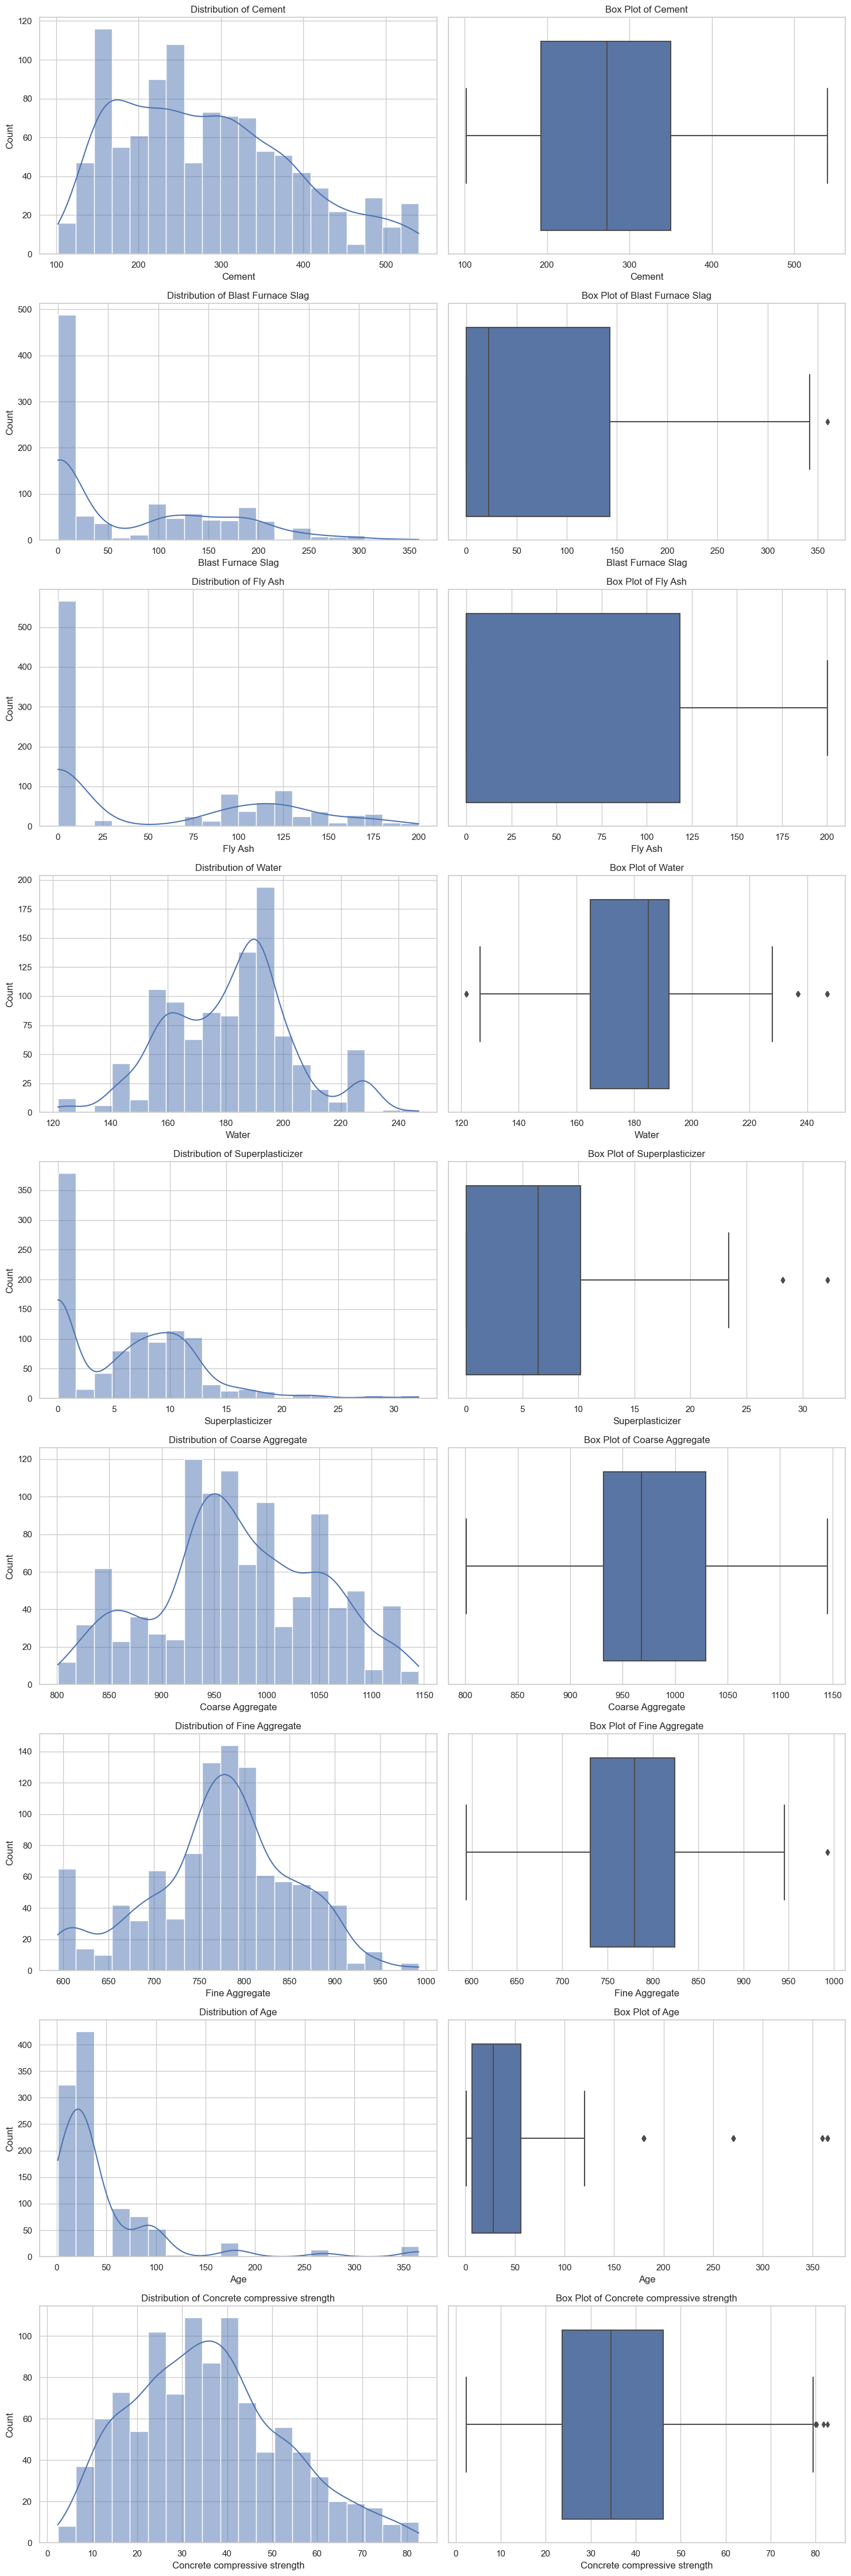

In [4]:
sns.set(style="whitegrid")
# Histograms and Box Plots
fig, axes = plt.subplots(len(combined_df.columns), 2, figsize=(15, 5 * len(combined_df.columns)))

for i, col in enumerate(combined_df.columns):
    # Histogram for distribution
    sns.histplot(combined_df[col], bins=20, kde=True, ax=axes[i][0])
    axes[i][0].set_title(f'Distribution of {col}')

    # Box plot for outliers
    sns.boxplot(x=combined_df[col], ax=axes[i][1])
    axes[i][1].set_title(f'Box Plot of {col}')

plt.tight_layout()
plt.show(block=True)

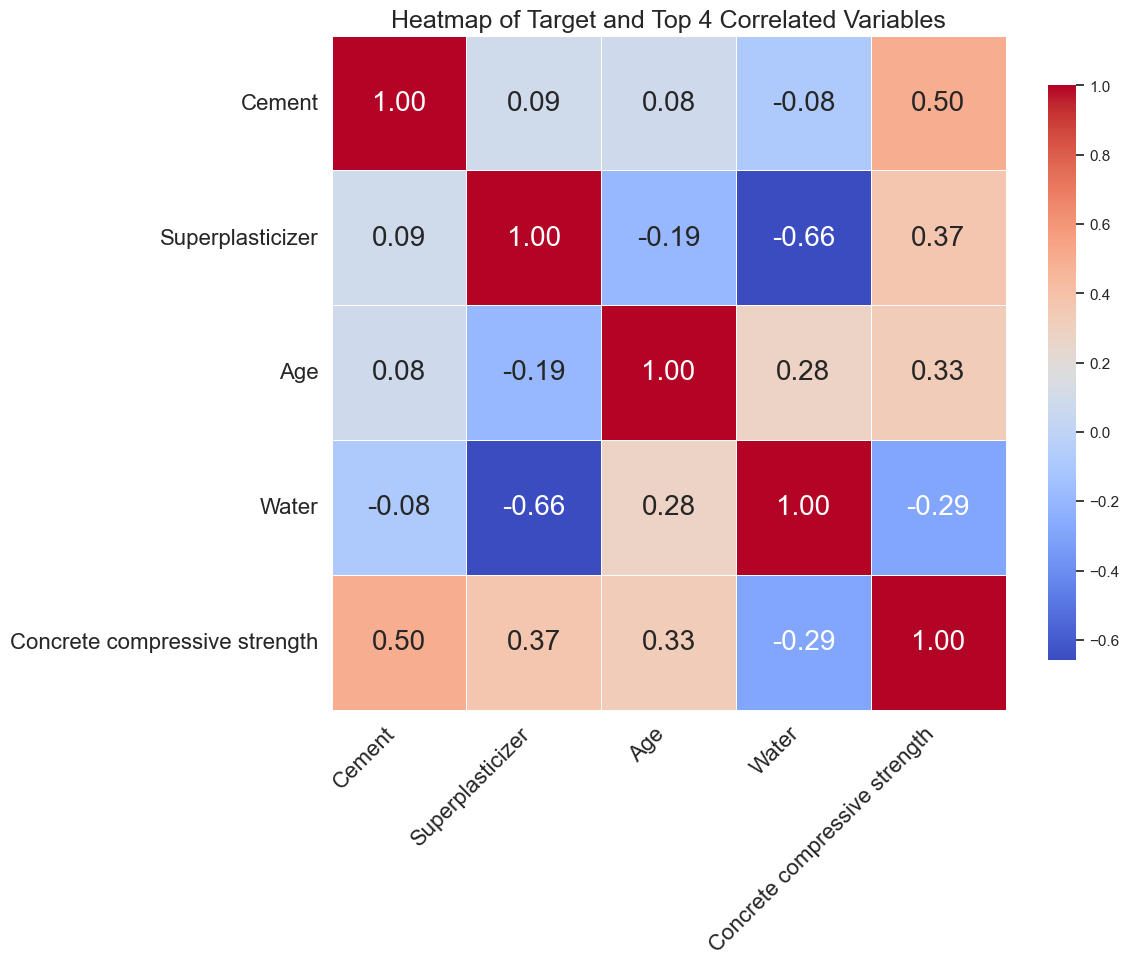

In [5]:
# Calculate the correlation matrix
corr_matrix = combined_df.corr()

# Extract correlations with the target, retaining sign
target_corr = corr_matrix['Concrete compressive strength']

# Sort the correlations by the absolute values and get the top 4 variables most correlated
# But keep the original correlation values
top_variables = target_corr.abs().sort_values(ascending=False)[1:5].index.tolist()

# Include the target variable in the list for the heatmap
top_variables.append('Concrete compressive strength')

# Filter the correlation matrix to include only these top correlated variables
filtered_corr_matrix = corr_matrix.loc[top_variables, top_variables]

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={'size': 20},  
            xticklabels=filtered_corr_matrix.columns,
            yticklabels=filtered_corr_matrix.index)
plt.title('Heatmap of Target and Top 4 Correlated Variables', size=18)

# Rotate x-axis labels and adjust bottom to make room for them
plt.xticks(rotation=45, ha='right', size=16)  # Rotate labels for better fit
plt.yticks(rotation=0, size=16)  # Keep y-axis labels horizontal for readability
plt.tight_layout()  

plt.show(block=True)

In [6]:
df = pd.concat([X, y], axis=1)
# Split features and target variable
X = df.drop(columns=['Concrete compressive strength'])
y = df['Concrete compressive strength']

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [8]:
# Data normalization
scaler = StandardScaler()
X_train_scaled_poly = scaler.fit_transform(X_train_poly)
X_test_scaled_poly = scaler.transform(X_test_poly)

# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 50,
    'min_data_in_leaf': 20,
    'max_depth': 8,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}


In [9]:
# Initialize LGBMRegressor
lgbm = LGBMRegressor(**params)

# Sequential feature selection
sfs = SequentialFeatureSelector(lgbm, n_features_to_select=21, direction='forward')
sfs.fit(X_train_scaled_poly, y_train)

# Transform features
X_train_sfs = sfs.transform(X_train_scaled_poly)
X_test_sfs = sfs.transform(X_test_scaled_poly)

# Train new LightGBM model with selected features
train_data_sfs = lgb.Dataset(X_train_sfs, label=y_train)
test_data_sfs = lgb.Dataset(X_test_sfs, label=y_test, reference=train_data_sfs)

In [10]:
model_sfs = lgb.train(
    params,
    train_data_sfs,
    num_boost_round=1000,
    valid_sets=[train_data_sfs, test_data_sfs],
    valid_names=['train', 'eval'],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Predictions with selected features
y_pred_sfs = model_sfs.predict(X_test_sfs, num_iteration=model_sfs.best_iteration)

# Evaluation metrics with selected features
mse_sfs = mean_squared_error(y_test, y_pred_sfs)
rmse_sfs = np.sqrt(mse_sfs)
mae_sfs = mean_absolute_error(y_test, y_pred_sfs)
r2_sfs = r2_score(y_test, y_pred_sfs)

print(f'MSE: {mse_sfs}')
print(f'RMSE: {rmse_sfs}')
print(f'MAE: {mae_sfs}')
print(f'R2 Score: {r2_sfs}')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[493]	train's rmse: 1.48586	eval's rmse: 3.79256
MSE: 14.38352329448394
RMSE: 3.792561574250831
MAE: 2.53294752060629
R2 Score: 0.9441800036824185


In [11]:
# Get the mask of selected features
selected_features_mask = sfs.get_support()

# Get the original feature names from polynomial features
poly_feature_names = poly.get_feature_names_out(input_features=X.columns)
# Print selected feature names
selected_feature_names = poly_feature_names[selected_features_mask]
print("Selected Features:")
for feature in selected_feature_names:
    print(feature)

Selected Features:
Cement
Blast Furnace Slag
Water
Superplasticizer
Coarse Aggregate
Fine Aggregate
Age
Cement Blast Furnace Slag
Cement Fly Ash
Cement Water
Cement Superplasticizer
Cement Fine Aggregate
Cement Age
Blast Furnace Slag Water
Fly Ash Superplasticizer
Fly Ash Coarse Aggregate
Water Coarse Aggregate
Water Fine Aggregate
Water Age
Superplasticizer Fine Aggregate
Fine Aggregate Age


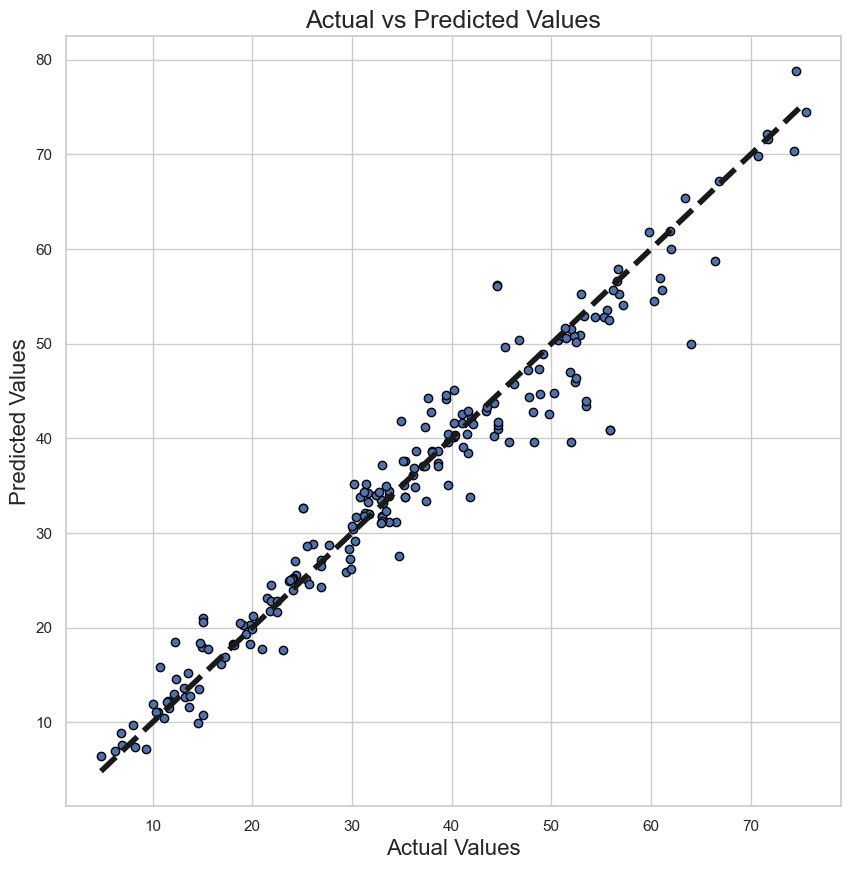

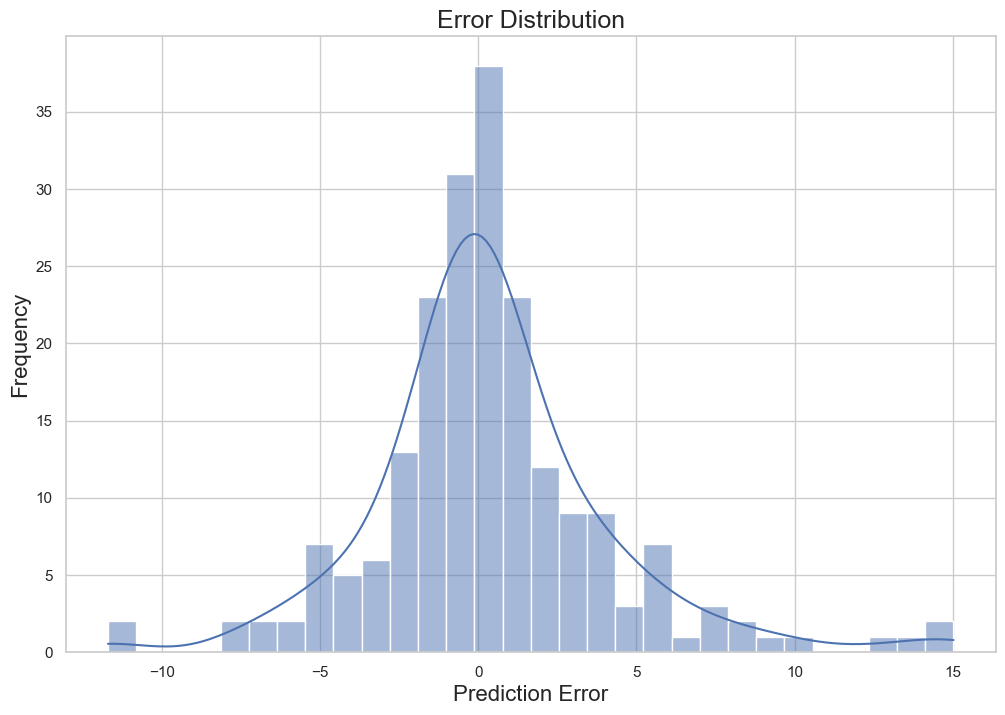

In [12]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Actual Values', fontsize=16)
    plt.ylabel('Predicted Values', fontsize=16)
    plt.title('Actual vs Predicted Values', fontsize=18)
    plt.show(block=True)


# Plot error distribution
def plot_error_distribution(y_test, y_pred):
    errors = y_test - y_pred
    plt.figure(figsize=(12, 8))
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title('Error Distribution', fontsize=18)
    plt.show(block=True)

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test, y_pred_sfs)

# Plot error distribution
plot_error_distribution(y_test, y_pred_sfs)

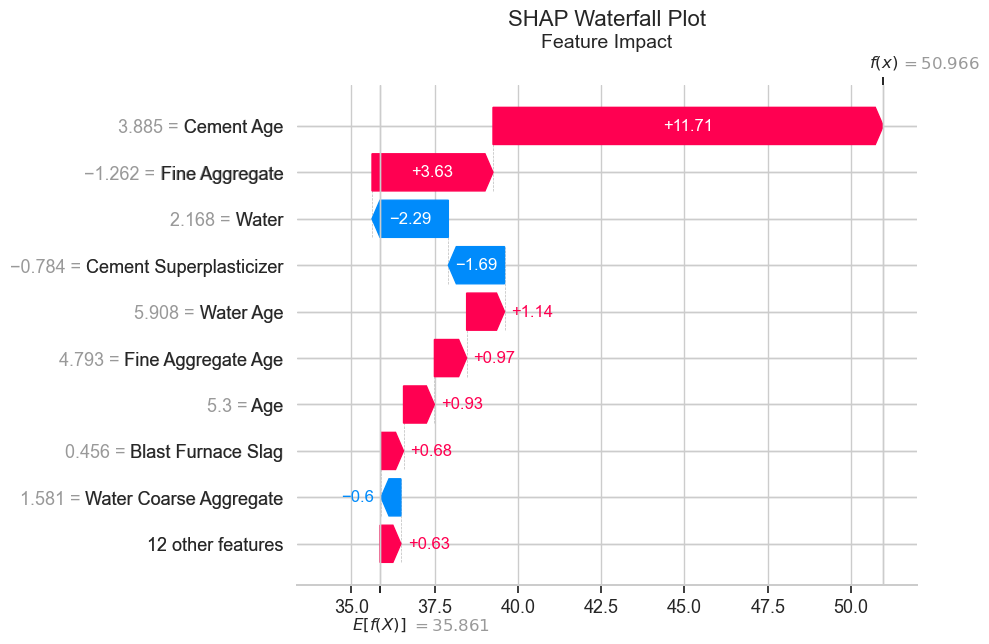

In [13]:
import shap
# SHAP explanation
explainer = shap.TreeExplainer(model_sfs)
shap_values = explainer.shap_values(X_test_sfs)

fig, ax = plt.subplots(figsize=(12, 12))
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                     base_values=explainer.expected_value,
                                     data=X_test_sfs[0],
                                     feature_names=selected_feature_names), show=False)

# Adjust text size
plt.title('SHAP Waterfall Plot', fontsize=16)
plt.xlabel('Feature Impact', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show(block=True)


In [14]:
# Stacking Ensemble Model

X = combined_df.drop('Concrete compressive strength', axis=1)  # Features: drop the target column
y = combined_df['Concrete compressive strength']  # Target: concrete compressive strength

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Initialize and fit the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base learners
base_learners = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('mlp1', MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)),
    ('mlp2', MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42))
]

# Initialize Stacking Regressor with a linear regression as a meta-learner
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=LinearRegression(),
    cv=5
)

# Train the stacking ensemble
stacking_model.fit(X_train_scaled, y_train)

# Predict and evaluate
predictions = stacking_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f'Stacking Ensemble MSE: {mse:.3f}')
print(f'Stacking Ensemble RMSE: {rmse:.3f}')
print(f'Stacking Ensemble MAE: {mae:.3f}')
print(f'Stacking Ensemble R² Score: {r2:.3f}')

Stacking Ensemble MSE: 20.575
Stacking Ensemble RMSE: 4.536
Stacking Ensemble MAE: 3.049
Stacking Ensemble R² Score: 0.920


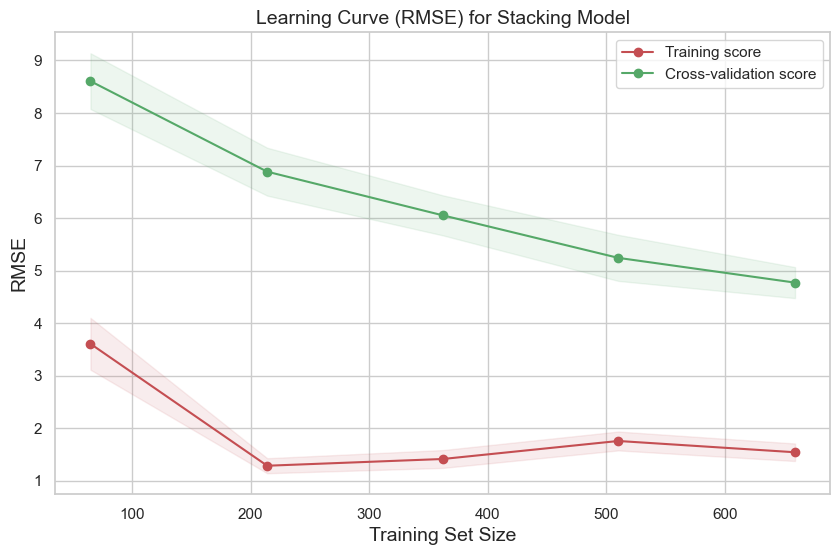

In [18]:
from sklearn.model_selection import learning_curve
# Define RMSE scorer
# Custom RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Assuming 'stacking_model' is already initialized and fitted as you described

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=stacking_model,
    X=X_train_scaled,  # Make sure to use your scaled training data
    y=y_train,         # Corresponding training labels
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,              # Cross-validation folding
    n_jobs=-1,         # Use all processors
    scoring=rmse_scorer
)

# Calculate the mean and standard deviation for training and test set scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve (RMSE) for Stacking Model", size=14)
plt.xlabel("Training Set Size",size=14)
plt.ylabel("RMSE",size=14)
plt.legend(loc="best")
plt.show(block=True)
